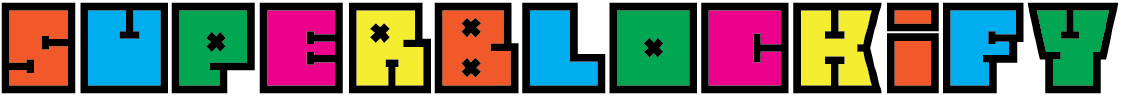

More info: [superblockify.city](https://superblockify.city)

# Getting started

This notebook runs a minimum working example, showing more parameter options and a FAQ.

The `superblockify` package works out of the box, meaning no further downloads are
necessary. Maps are downloaded from the OpenStreetMap API and population data is
downloaded from the [GHSL-POP 2023](https://ghsl.jrc.ec.europa.eu/ghs_pop2023.php)
dataset. Only tiles needed are being cached in the `data/ghsl` folder.

As example, we will try to partition the French city of Lyon with the
`ResidentialPartitioner` class. Afterward we will save the results to a geopackage
file that can easily be opened and edited in QGIS.

First, import the package.

In [ ]:
import superblockify as sb

# sb.config.set_log_level("DEBUG")   # set to see debug logs
sb.config.Config.FULL_RASTER = None  # set if you own the full ghsl raster 
# (GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0.tif)
# otherwise the package will automatically download the needed tiles

## Initialization

For this example we will use the `ResidentialPartitioner` class.
It is a class that partitions a city into superblocks based on the residential
street tags in OpenStreetMap.
First, we initialize the partitioner with the city name and a search string.

In [ ]:
part = sb.ResidentialPartitioner(
    name="Scheveningen_test", city_name="Scheveningen", search_str="Scheveningen, NL",
    unit="time",  # "time", "distance", any other edge attribute, or None to count edges
)

This will download the map of Lyon, preprocess it, output some statistics
and store it in the `data/graphs` folder for use later.
Any other partitioner for Scheveningen, given the same `city_name`, will use the same
preprocessed, locally stored map.
Population tiles are cached in the `data/ghsl` folder (if not using the full raster).

## Partitioning

Next, we will show the quickest way to partition the city and calculate the metrics
all in one go.

In [ ]:
part.run(
    calculate_metrics=True,  # set to False if you are not interested in metrics
    make_plots=True,  # set to False if you are not interested in plots
    replace_max_speeds=False,  # set to true to overwrite the OSM speed limits
    # -> with 15 km/h inside Superblocks and 50 km/h outside
    # If the approach has specific parameters, you can set them here
)

As you see, this partitions the city and shows the relative increase of the distance metric.
All shown plots are saved as pdf to the `data/results/Scheveningen_test` folder.

It is possible to save and load a partitioner object to continue the work later.

In [ ]:
# part.save()
# part.load("Scheveningen_test")

The most illustrative and interactive way to view the results is to save them to a
geopackage file. This file can be opened in [QGIS](https://www.qgis.org/en/site/) and edited further.

In [ ]:
sb.save_to_gpkg(part, save_path=None)

This will save the partitioning results to `data/results/Scheveningen_test/Scheveningen_test.gpkg`.
If you calculated the metrics before, they will be available in the layers, for each 
Superblock. This includes more metrics than shown in the plots earlier.
The name of the components is saved into a "classification" edge 
attribute. The sparse graph is saved with the value "SPARSE" into the 
"classification" edge attribute.

To learn more about the inner workings and background of the package, please
see the next Reference section. Otherwise, you can also check out the
[API documentation](api/index)

## FAQ

### Can I export the plots to another format?

Yes, you can export the plots to any format supported by matplotlib.
Just change the `PLOT_SUFFIX` in the `Config` class to the desired format.

In [ ]:
sb.config.Config.PLOT_SUFFIX = "png"  # or "svg", "pdf", etc.

### The downloaded city is too big/small/not the right city, can I change this?

The deciding string for the area to download is the `search_str`.
Finding a fitting OSM area is via the Nominatim API.
If you want to see your area before downloading, use
the [Nominatim Search](https://nominatim.openstreetmap.org/ui/search.html).
It helps to be more specific, e.g. "Lyon, France" instead of just "Lyon".
Otherwise, OSM relations IDs, e.g. `R120965`, can be used.

To re-download the map, pass `reload_graph=True` when initializing the partitioner.

### The Superblocks look too big/small/random when using the `ResidentialPartitioner`, why is that?

The `ResidentialPartitioner` uses the residential street tags to find the Superblocks.
OSM data quality and the way streets are tagged varies, this is reflected for this approach.
The `BetweennessPartitioner` tries to combat this by using the betweenness centrality
of the streets, not the tags. Try this approach if the Superblocks are not satisfactory.


In [ ]:
part = sb.BetweennessPartitioner(
    name="Scheveningen_test_betweenness", city_name="Scheveningen",
    search_str="Scheveningen, NL",
)
part.run(
    percentile=85.0,  # aimed percentage of streets for Superblocks
    scaling="normal",  # type of scaling for the betweenness centrality:
    # "normal", "length", "linear"
    max_range=None  # maximum range of the betweenness centrality, in meters, e.g. 3500
)

### My country has another maximum speed limit, can I change this?

When calculating the metrics and using `replace_max_speeds=True`,
the maximum speed limits are set to 15 km/h inside Superblocks
and 50 km/h outside of them. If you want to change these values, you can do so
by setting the `V_MAX_LTN` and `V_MAX_SPARSE` attributes in the `Config` class.

In [ ]:
sb.config.Config.V_MAX_LTN = 30  # km/h
sb.config.Config.V_MAX_SPARSE = 60  # km/h

### Some streets I know are not being used in the partitioning, why is that?

When downloading the map from OpenStreetMap, we use a specific network filter, which 
should include the car network.

In [ ]:
sb.config.Config.NETWORK_FILTER

### Some process is taking too long or suddenly stops, what can I do?

If there are warnings or logs that indicate a problem, they might point to the issue.
Be aware that, when analyzing a large city, superblockify needs sufficient resources.
If it runs out of memory, some processes might stop abruptly without warning.
To combat this, you can either try to find a `search_str` with a smaller area or
set the `MAX_NODES` attribute in the `Config` class to a lower value.
When initializing a partitioner, the street network is cut off at this number of nodes,
including the most central nodes. By default, this is set to 20,000.

For further settings, see the other attributes in the `Config` class.

In [ ]:
print(sb.config.Config.__doc__)

If you run into any other issues, feel free to look into the [API documentation](api/index),
[Source Code](https://github.com/NERDSITU/superblockify/),
activate debug logs `sb.config.set_log_level("DEBUG")`
or finally [open a new issue](https://github.com/NERDSITU/superblockify/issues/new).